In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

background = None
accumulated_weight = 0.5

#Creating the dimensions for the ROI...
ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

def cal_accum_avg(frame, accumulated_weight):
    global background
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [13]:
train_path = r'E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\\train'
test_path = r'E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\\test'


In [14]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    _ , thresholded = cv2.threshold(diff, threshold,255,cv2.THRESH_BINARY)

    # Grab the external contours for the image
    contours, hierarchy = cv2.findContours(thresholded.copy(),
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        return (thresholded, hand_segment_max_cont)

In [15]:
cam = cv2.VideoCapture(0)

num_frames = 0
element = 5
num_imgs_taken = 0

while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",(80, 400),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
         #Time to configure the hand specifically into the ROI...
    elif num_frames <= 300: 
        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)
        
        
        if hand is not None:
            thresholded, hand_segment = hand
            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element),(70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            
    else:
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For"+ str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
        
            if num_imgs_taken <= 300:
                #====================================================================================
                #====================================================================================
                #====================================================================================
                if num_imgs_taken % 8 ==0:
                    imgpath = test_path+"\\"+str(element)+"\\" + str(num_imgs_taken+300) + '.jpg'
                    imgpath.encode('unicode_escape')
                    cv2.imwrite(imgpath, thresholded)
                else:
                    imgpath = train_path+"\\"+str(element)+"\\" + str(num_imgs_taken+300) + '.jpg'
                    imgpath.encode('unicode_escape')
                    cv2.imwrite(imgpath, thresholded)
                
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            
    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "Sign Language Interpreter", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)

    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break
# Releasing the camera & destroying all the windows...

cv2.destroyAllWindows()
cam.release()

In [4]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

imgs, labels = next(train_batches)

Found 1315 images belonging to 5 classes.
Found 1315 images belonging to 5 classes.
Found 190 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

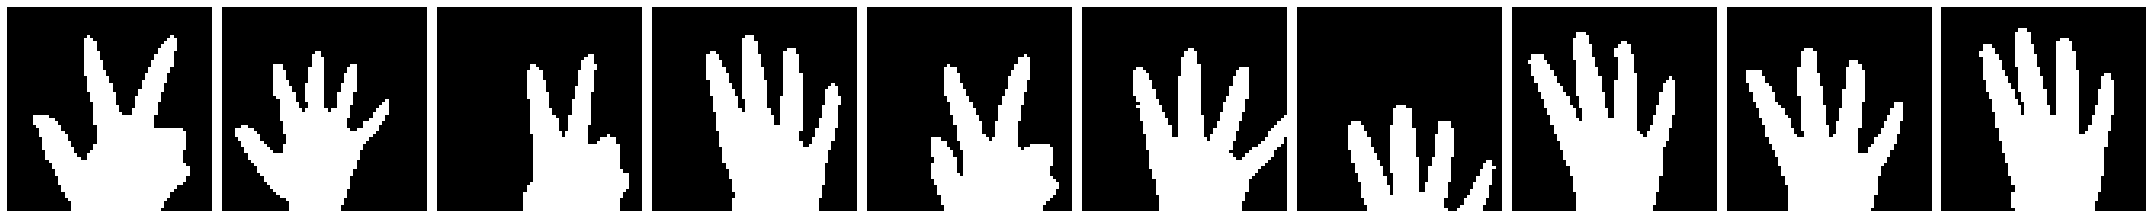

(10, 64, 64, 3)
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [5]:
#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

 

plotImages(imgs)
print(imgs.shape)
print(labels)

In [6]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="tanh", input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="tanh", padding = 'same',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(7, 7), activation="tanh", padding = 'same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=256, kernel_size=(9, 9), activation="tanh", padding = 'same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=1))

model.add(Conv2D(filters=128, kernel_size=(11, 11), activation="tanh", padding = 'same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=1))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(64,activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128,activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256,activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128,activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64,activation="tanh",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(5,activation ="softmax"))

In [7]:
opt = SGD(lr=0.01)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='accuracy', min_delta=0, patience=3, verbose=0, mode='auto')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r"E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\\model.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

callbacks = [reduce_lr,early_stop,model_checkpoint]

In [8]:
history = model.fit(train_batches, epochs=50, shuffle = True,callbacks=callbacks, validation_data = test_batches)

Epoch 1/50
132/132 [==============================] - 38s 263ms/step - loss: 3.5595 - accuracy: 0.2674 - val_loss: 2.8918 - val_accuracy: 0.3474

Epoch 00001: saving model to E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\model.h5
Epoch 2/50
132/132 [==============================] - 32s 245ms/step - loss: 3.2520 - accuracy: 0.3373 - val_loss: 3.1774 - val_accuracy: 0.3737

Epoch 00002: saving model to E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\model.h5
Epoch 3/50
132/132 [==============================] - 33s 251ms/step - loss: 3.0251 - accuracy: 0.3869 - val_loss: 3.6861 - val_accuracy: 0.3158

Epoch 00003: saving model to E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\model.h5
Epoch 4/50
132/132 [==============================] - 32s 242ms/step - loss: 2.7923 - accuracy: 0.4553 - val_loss: 2.1756 - val_accuracy: 0.7579

Epoch 00004: saving model to E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\model.h5
Epoch 5/50
132/132 [==============================] - 33s 252ms/step - loss: 2.5886 

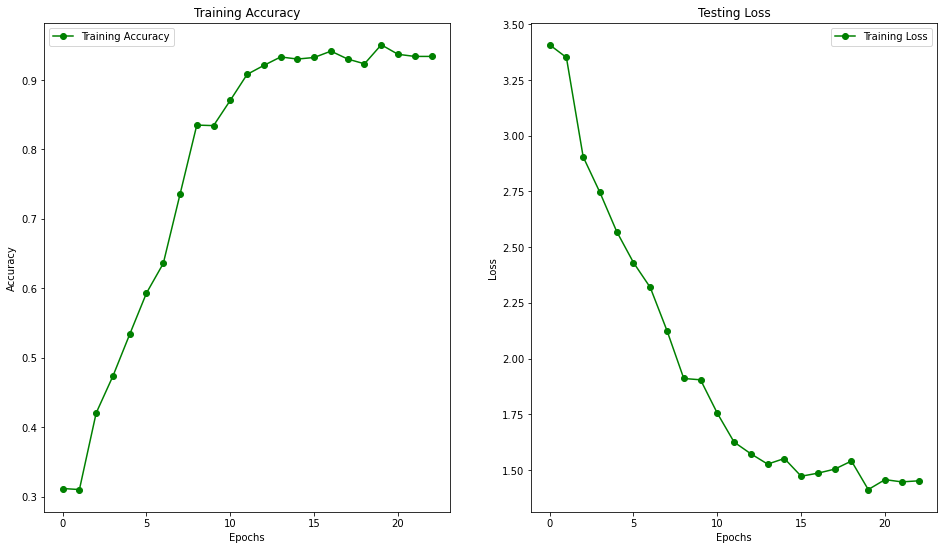

In [16]:
epochs = [i for i in range(23)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].set_title('Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

![Accuracy and Loss](pptImgs\\accuracyAndLoss.png)


In [59]:
# For getting next batch of testing imgs...
imgs, labels = next(test_batches) 

scores = model.evaluate(imgs, labels, verbose=0)
model.save('model.h5')

In [84]:
word_dict = {0:'One',1:'Ten',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine'}

In [54]:
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [55]:
model = keras.models.load_model(r"E:\\College\\Sem 32\\Open Lab\\OpenLabsFinal\\model.h5")

background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [56]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()
    # flipping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()
    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    if num_frames < 70:
        cal_accum_avg(gray_frame, accumulated_weight)
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    else: 
        # segmenting the hand region
        hand = segment_hand(gray_frame)
        # Checking if we are able to detect the hand...
        if hand is not None:
            thresholded, hand_segment = hand
            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            cv2.imshow("Thesholded Hand Image", thresholded)
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,(1,thresholded.shape[0],thresholded.shape[1],3))
            pred = model.predict(thresholded)
            predictedWord = word_dict[np.argmax(pred)]
            cv2.putText(frame_copy,predictedWord,(170, 45),cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)

    # incrementing the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.putText(frame_copy, "Sign Language Interpreter",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)

    # Close windows with Esc
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()